# Gaussian Process Factor Analysis Regression

## Introduction

Gaussian Process Factor Analysis (GPFA), introduced in [this paper](https://papers.nips.cc/paper/2008/file/ad972f10e0800b49d76fed33a21f6698-Paper.pdf) learns underlying latent trajectories for the outputs while smoothing the data. A more [recent paper](https://papers.nips.cc/paper/2020/file/6d79e030371e47e6231337805a7a2685-Paper.pdf) suggests scalable implementations for GPFA (in the [supplement](https://papers.nips.cc/paper/2020/file/6d79e030371e47e6231337805a7a2685-Supplemental.pdf) ) as well as extending GPFA with kernels for dynamical systems. The implementation in this notebook is developed with this GPFA for Dynamical Systems (GPFADS) extension in mind. 

GPFA(DS) are useful when you want to simultaneous smooth and reduce the dimensionality of neural data. 

Given test_xpoints $t$, $M$ latent variables $x$ with underlying kernels $k_1, ...k_M$, and observations (neural data) $y$ from $N$ neurons, the observations in GPFA are are assumed to arise as follows:
- The latents variables are independent of eachother:
$$  k[x_i(t),x_i(t')] = k_i(t,t')
$$

- We write the above in a vector of latents as:
$$k[\mathbf{x}(t), \mathbf{x}(t')] = \sum_{i=1}^{M}k_i(t,t')\otimes \mathbf{e_i}
$$

- We combine the latents into observations as follows:
$$k[\mathbf{y}_i(t), \mathbf{y}_i(t')] = (C) k( \mathbf{x}(t) , \mathbf{x}(t'))(C^T)
$$

where $k_i$ is a standard kernel (e.g. RBF) that operates on the inputs.
$\mathbf{e}_i$ is a unit vector of length $M$ with nonzero element at index $i$, $\otimes$ is the Kronecker product, and $C\in NxM$ is the mixing matrix, indicating how latents are combined into observations.

In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data
In the next cell, we set up the training data for this example. We'll be using 1000 regularly spaced points on [0,100], our data will be drawn from the generative model assumed in GPFA.

In [2]:
def generate_GPFA_Data(seed=0, n_timepoints=100, n_latents=2, n_outputs=50, length_scales = [.01,10],start_time=-5, end_time = 5,zero_mean = True):
    torch.manual_seed(seed)
    np.random.seed(seed)
    timepoints = torch.linspace(start_time, end_time, n_timepoints)
    tau = torch.tensor(length_scales)
    C = torch.tensor(np.random.normal(scale=1./np.sqrt(n_latents),size=(n_outputs,n_latents))).float()
    if zero_mean:
        d = torch.zeros(size=(n_outputs,1)).float()
    else:
        d = torch.tensor(np.random.uniform(size=(n_outputs,1))).float()
    R = torch.tensor(np.diag(np.random.uniform(size=(n_outputs,), low=.1))).float()
    kernels = [gpytorch.kernels.RBFKernel() for t in tau]
    for t in range(len(tau)):
        kernels[t].lengthscale = tau[t]

    xs = torch.stack([
        gpytorch.distributions.MultivariateNormal(
            torch.zeros(n_timepoints), 
            k(timepoints,timepoints) 
        ).sample()
        for k in kernels])

    ys = gpytorch.distributions.MultivariateNormal((C@xs + d).T, R).sample()
    
    xs = xs.T.contiguous()
    
    return timepoints, tau, C, d, R, kernels, xs, ys

In [3]:
n_latents=2
n_outputs=20
n_timepoints = 100
length_scales = [.1,.2]
start_time = 0
end_time = 1
train_x, tau, C, d, R, kernels, xs, train_y = generate_GPFA_Data(
    seed=10, n_timepoints=n_timepoints, n_latents=n_latents, n_outputs=n_outputs, 
    length_scales = length_scales,start_time = start_time, end_time = end_time, zero_mean =True)

/scratch/jts58/devenv/lib/python3.7/site-packages/gpytorch-1.4.0-py3.7.egg/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


## Define a multitask model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Exact_GPs/Simple_GP_Regression.ipynb).
The differences:

1. We're going to wrap ConstantMean with a `MultitaskMean`. This makes sure we have a mean function for each output dimension.
2. Rather than just using a RBFKernel, we're using that in conjunction with a `GPFAKernel`. This gives us the covariance function described in the introduction.
3. We're using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood`. This allows us to deal with the predictions/outputs in a nice way. For example, when we call MultitaskMultivariateNormal.mean, we get a `T x N` matrix back (where `T` is the number of test_xpoints).


- [ ] TODO: verify below

You may also notice that we don't use a ScaleKernel, since the GPFAKernel will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [4]:
from gpytorch.kernels import GPFAKernel
from gpytorch.lazy import DiagLazyTensor, KroneckerProductLazyTensor, KroneckerProductDiagLazyTensor

class GPFAModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, latent_covar_modules,  num_latents, num_obs):
        #TODO: infer number latents / obs from train_x / train_y?
        super(GPFAModel, self).__init__(train_x, train_y, likelihood)
        
        self.num_latents = num_latents
        self.num_obs = num_obs
        
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_obs
        )
        self.covar_module = GPFAKernel(latent_covar_modules,num_latents, num_obs)
        
    def forward(self, x):
        return gpytorch.distributions.MultitaskMultivariateNormal(self.mean_module(x), self.covar_module(x))
    
    def latent_posterior(self, x):
        r'''
        See equations 4 and 5 in `Non-reversible Gaussian processes for 
        identifying latent dynamical structure in neural data`_

        .. _Non-reversible Gaussian processes for identifying latent dynamical structure in neural data:
        https://papers.nips.cc/paper/2020/file/6d79e030371e47e6231337805a7a2685-Paper.pdf
        '''
        I_t = DiagLazyTensor(torch.ones(len(x)))
        combined_noise = (likelihood.task_noises if likelihood.has_task_noise else torch.zeros(likelihood.num_tasks)) + (likelihood.noise if likelihood.has_global_noise else 0)
        Kyy = model.covar_module(x)+KroneckerProductDiagLazyTensor(I_t, DiagLazyTensor(combined_noise ))

        Kxx = model.covar_module.latent_covar_module(x)

        # TODO: Would this be more efficient as a block diagonal lazy tensor?
        C_Kron_I = KroneckerProductLazyTensor(I_t, model.covar_module.C)


        mean_rhs = (train_y - model.mean_module(x)).view(*(train_y.numel(),)) # vertically stacks after doing the subtraction

        latent_mean = Kxx@C_Kron_I.t()@Kyy.inv_matmul(mean_rhs)
        latent_mean = latent_mean.view(*(len(x),int(latent_mean.shape[0]/len(x))))

        cov_rhs = C_Kron_I@Kxx
        latent_cov =  Kxx - Kxx@C_Kron_I.t()@Kyy.inv_matmul(cov_rhs.evaluate()) # this evaluate is going to slow things down at scale, TODO: figure out how to remove it

        return gpytorch.distributions.MultitaskMultivariateNormal(latent_mean, latent_cov)


In [5]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_outputs)
kernels = [gpytorch.kernels.RBFKernel() for t in range(n_latents)]
model=GPFAModel(train_x,train_y, likelihood,  kernels, n_latents, n_outputs)

- [ ] TODO: make num obs / outputs consistent wording

### Train the model hyperparameters

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
with gpytorch.settings.fast_computations(False,False,False):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %2d/%d - Loss: %.3f, Lengthscale 1: %.3f, Lengthscale 2: %.3f' 
              % (i + 1, training_iterations, loss.item(), kernels[0].lengthscale.float(), kernels[1].lengthscale.float()))
        optimizer.step()

/scratch/jts58/devenv/lib/python3.7/site-packages/torch-1.7.1-py3.7-linux-x86_64.egg/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Iter  1/50 - Loss: 148.949, Lengthscale 1: 0.693, Lengthscale 2: 0.693
Iter  2/50 - Loss: 145.733, Lengthscale 1: 0.744, Lengthscale 2: 0.644
Iter  3/50 - Loss: 142.930, Lengthscale 1: 0.796, Lengthscale 2: 0.606
Iter  4/50 - Loss: 140.534, Lengthscale 1: 0.844, Lengthscale 2: 0.568
Iter  5/50 - Loss: 138.392, Lengthscale 1: 0.877, Lengthscale 2: 0.532
Iter  6/50 - Loss: 136.425, Lengthscale 1: 0.883, Lengthscale 2: 0.496
Iter  7/50 - Loss: 134.536, Lengthscale 1: 0.867, Lengthscale 2: 0.461
Iter  8/50 - Loss: 132.629, Lengthscale 1: 0.838, Lengthscale 2: 0.428
Iter  9/50 - Loss: 130.615, Lengthscale 1: 0.800, Lengthscale 2: 0.395
Iter 10/50 - Loss: 128.477, Lengthscale 1: 0.759, Lengthscale 2: 0.364
Iter 11/50 - Loss: 126.260, Lengthscale 1: 0.715, Lengthscale 2: 0.335
Iter 12/50 - Loss: 124.037, Lengthscale 1: 0.671, Lengthscale 2: 0.308
Iter 13/50 - Loss: 121.867, Lengthscale 1: 0.627, Lengthscale 2: 0.283
Iter 14/50 - Loss: 119.735, Lengthscale 1: 0.583, Lengthscale 2: 0.259
Iter 1

### Make predictions with the model

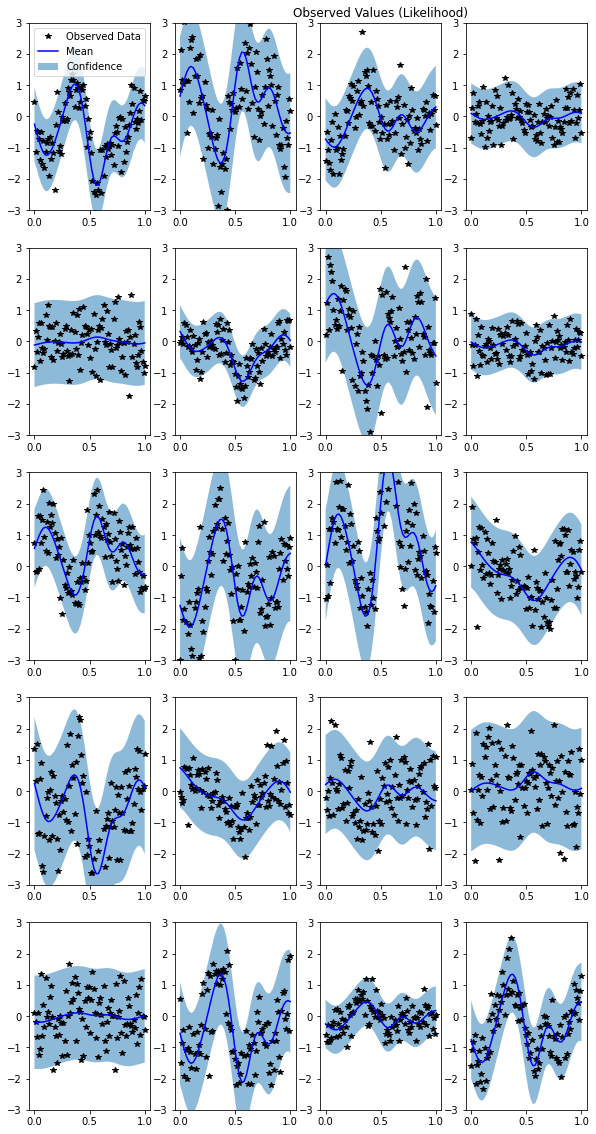

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axes = plt.subplots(5, 4, figsize=(10, 20))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task
for i, ax in enumerate(axes.flatten()):
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, i].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, i].numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.numpy(), lower[:, i].numpy(), upper[:, i].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    if i==0:
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
    if i==2:
        ax.set_title('Observed Values (Likelihood)')


None

### Find the Latents

These latents will only 'match' up to an ordering and negation of the true latents. The confidence regions of the posterior latents do not necessarily include the true latents as 
- [ ] Figure out how to put this in the model in some way

- [ ] TODO: ask what the deal is w what's most efficient around Kronecker structure / block diagonal stuff

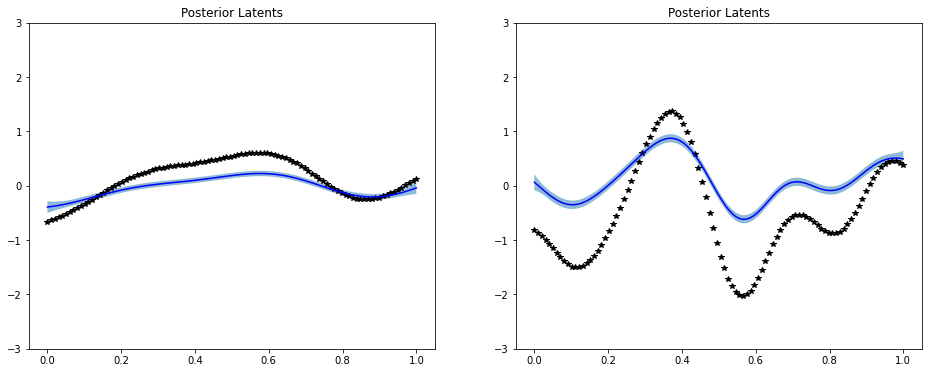

In [8]:
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots( 1, n_latents, figsize=(16, 6))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    predictions = model.latent_posterior(test_x)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
    
    #mean_posterior_latent = true_latent_posterior.mean
    #lower_posterior_latent, upper_posterior_latent = true_latent_posterior.confidence_region()
    

for i in range(n_latents):
    ax = axs[i]
    # Plot true hidden latents as black stars
    ax.plot(train_x.cpu().detach().numpy(), (-1 if i==0 else 1)*xs[:, (i-1)%2].cpu().detach().numpy(), 'k*', label= "Hidden Latents")
    # Predictive mean as blue line
    ax.plot(test_x.cpu().numpy(), mean[:, i].cpu().detach().numpy(), 'b', label='Posterior Latent Mean')
    # Shade in confidence 
    ax.fill_between(test_x.cpu().numpy(), lower[:, i].cpu().numpy(), upper[:, i].cpu().numpy(), alpha=.5, label="Posterior Latent Confidence Region")
    ax.set_ylim([-3, 3])
#
    ax.set_title('Posterior Latents')